<a href="https://colab.research.google.com/github/kushal-jaat/ASD-assignment-3/blob/main/salesdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
import pandas as pd

# Mount Google Drive to access the datasets
from google.colab import drive
drive.mount('/content/drive')
# Load the datasets using the provided paths
sales_data = pd.read_csv('/content/drive/My Drive/housing/housing-sales-borough.csv')  # Sales dataset path

# Display the first few rows to confirm loading
print("Sales Data Sample:")
print(sales_data.head())

Mounted at /content/drive


<ipython-input-2-6b011c1b3bfd>:7: DtypeWarning: Columns (8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  sales_data = pd.read_csv('/content/drive/My Drive/housing/housing-sales-borough.csv')  # Sales dataset path


Sales Data Sample:
   Serial Number  List Year Date Recorded     Town          Address  \
0        2020177       2020    04/14/2021  Ansonia    323 BEAVER ST   
1        2020225       2020    05/26/2021  Ansonia   152 JACKSON ST   
2        2020348       2020    09/13/2021  Ansonia  230 WAKELEE AVE   
3        2020090       2020    12/14/2020  Ansonia      57 PLATT ST   
4         200500       2020    09-07-2021     Avon     245 NEW ROAD   

   Assessed Value  Sale Amount  Sales Ratio Property Type Residential Type  \
0          133000     248400.0       0.5354   Residential    Single Family   
1          110500     239900.0       0.4606   Residential     Three Family   
2          150500     325000.0       0.4630    Commercial              NaN   
3          127400     202500.0       0.6291   Residential       Two Family   
4          217640     400000.0       0.5441   Residential    Single Family   

  Non Use Code Assessor Remarks OPM remarks                    Location  
0          

In [3]:
# Inspect the sales_data structure
print("Sales Data Information:")
sales_data.info()

print("\nSales Data Column Summary:")
print(sales_data.describe(include='all'))

print("\nSales Data Sample:")
print(sales_data.head())


Sales Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 14 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Serial Number     1048575 non-null  int64  
 1   List Year         1048575 non-null  int64  
 2   Date Recorded     1048573 non-null  object 
 3   Town              1048575 non-null  object 
 4   Address           1048524 non-null  object 
 5   Assessed Value    1048575 non-null  int64  
 6   Sale Amount       1048575 non-null  float64
 7   Sales Ratio       1048575 non-null  float64
 8   Property Type     666129 non-null   object 
 9   Residential Type  655012 non-null   object 
 10  Non Use Code      301508 non-null   object 
 11  Assessor Remarks  160753 non-null   object 
 12  OPM remarks       11422 non-null    object 
 13  Location          249058 non-null   object 
dtypes: float64(2), int64(3), object(9)
memory usage: 112.0+ MB

Sales Data Col

In [4]:
# Check for missing values in sales_data
print("Missing Values in Sales Data:")
print(sales_data.isnull().sum())

Missing Values in Sales Data:
Serial Number             0
List Year                 0
Date Recorded             2
Town                      0
Address                  51
Assessed Value            0
Sale Amount               0
Sales Ratio               0
Property Type        382446
Residential Type     393563
Non Use Code         747067
Assessor Remarks     887822
OPM remarks         1037153
Location             799517
dtype: int64


In [5]:
# Check unique types in each column to identify any mixed data types across the entire dataset
for col in sales_data.columns:
    print(f"\nUnique types in column '{col}':")
    print(sales_data[col].apply(type).value_counts())



Unique types in column 'Serial Number':
Serial Number
<class 'int'>    1048575
Name: count, dtype: int64

Unique types in column 'List Year':
List Year
<class 'int'>    1048575
Name: count, dtype: int64

Unique types in column 'Date Recorded':
Date Recorded
<class 'str'>      1048573
<class 'float'>          2
Name: count, dtype: int64

Unique types in column 'Town':
Town
<class 'str'>    1048575
Name: count, dtype: int64

Unique types in column 'Address':
Address
<class 'str'>      1048524
<class 'float'>         51
Name: count, dtype: int64

Unique types in column 'Assessed Value':
Assessed Value
<class 'int'>    1048575
Name: count, dtype: int64

Unique types in column 'Sale Amount':
Sale Amount
<class 'float'>    1048575
Name: count, dtype: int64

Unique types in column 'Sales Ratio':
Sales Ratio
<class 'float'>    1048575
Name: count, dtype: int64

Unique types in column 'Property Type':
Property Type
<class 'str'>      666129
<class 'float'>    382446
Name: count, dtype: int64



In [6]:
# Replace float values in 'Address' and 'Non Use Code' with "Unknown" to make the data consistent
sales_data['Address'] = sales_data['Address'].fillna("Unknown")
sales_data['Non Use Code'] = sales_data['Non Use Code'].fillna("Unknown").astype(str)

# Verify the changes
print("\nUpdated types in 'Address':")
print(sales_data['Address'].apply(type).value_counts())

print("\nUpdated types in 'Non Use Code':")
print(sales_data['Non Use Code'].apply(type).value_counts())



Updated types in 'Address':
Address
<class 'str'>    1048575
Name: count, dtype: int64

Updated types in 'Non Use Code':
Non Use Code
<class 'str'>    1048575
Name: count, dtype: int64


In [7]:
# Reconfirm filling of 'Address' and 'Non Use Code' if necessary
sales_data['Address'] = sales_data['Address'].fillna("Unknown")
sales_data['Non Use Code'] = sales_data['Non Use Code'].fillna("Unknown").astype(str)


# Drop unnecessary columns such as 'Assessor Remarks', 'OPM remarks', 'Location' (if these are not useful for modeling)
sales_data.drop(columns=['Assessor Remarks', 'OPM remarks', 'Location'], inplace=True)

# Display a summary to verify
print("Updated sales_data info after handling missing values and dropping unnecessary columns:")
print(sales_data.info())


Updated sales_data info after handling missing values and dropping unnecessary columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 11 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Serial Number     1048575 non-null  int64  
 1   List Year         1048575 non-null  int64  
 2   Date Recorded     1048573 non-null  object 
 3   Town              1048575 non-null  object 
 4   Address           1048575 non-null  object 
 5   Assessed Value    1048575 non-null  int64  
 6   Sale Amount       1048575 non-null  float64
 7   Sales Ratio       1048575 non-null  float64
 8   Property Type     666129 non-null   object 
 9   Residential Type  655012 non-null   object 
 10  Non Use Code      1048575 non-null  object 
dtypes: float64(2), int64(3), object(6)
memory usage: 88.0+ MB
None


In [8]:
# Drop date-related columns as they are not essential for prediction
sales_data.drop(columns=['Date Recorded'], inplace=True)

# Verify the final structure of sales_data
print("Final sales_data info after dropping date-related columns:")
print(sales_data.info())


Final sales_data info after dropping date-related columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Serial Number     1048575 non-null  int64  
 1   List Year         1048575 non-null  int64  
 2   Town              1048575 non-null  object 
 3   Address           1048575 non-null  object 
 4   Assessed Value    1048575 non-null  int64  
 5   Sale Amount       1048575 non-null  float64
 6   Sales Ratio       1048575 non-null  float64
 7   Property Type     666129 non-null   object 
 8   Residential Type  655012 non-null   object 
 9   Non Use Code      1048575 non-null  object 
dtypes: float64(2), int64(3), object(5)
memory usage: 80.0+ MB
None


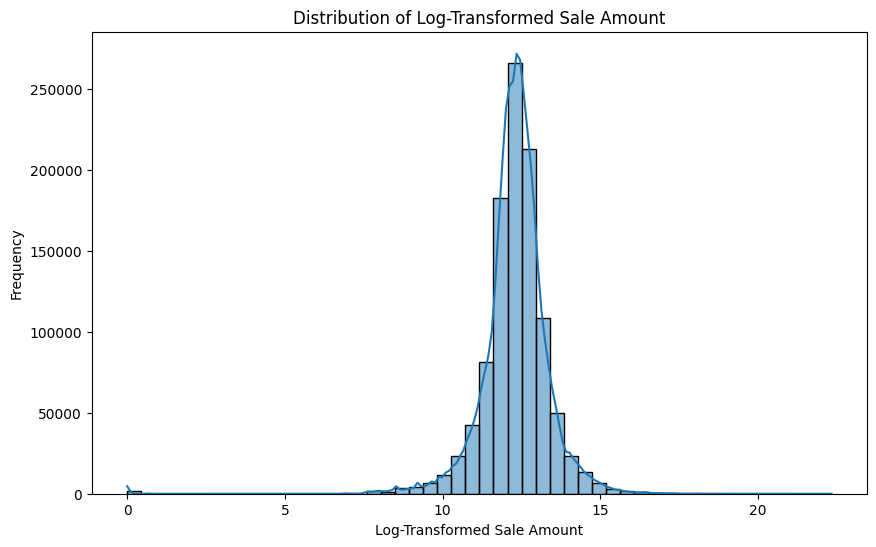

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Apply log transformation to 'Sale Amount', adding 1 to avoid log(0)
sales_data['Sale Amount Log'] = np.log1p(sales_data['Sale Amount'])

# Plot the transformed distribution
plt.figure(figsize=(10, 6))
sns.histplot(sales_data['Sale Amount Log'], bins=50, kde=True)
plt.title('Distribution of Log-Transformed Sale Amount')
plt.xlabel('Log-Transformed Sale Amount')
plt.ylabel('Frequency')
plt.show()


In [10]:
# Calculate IQR for 'Sale Amount Log'
Q1 = sales_data['Sale Amount Log'].quantile(0.25)
Q3 = sales_data['Sale Amount Log'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
sales_data_cleaned = sales_data[
    (sales_data['Sale Amount Log'] >= lower_bound) &
    (sales_data['Sale Amount Log'] <= upper_bound)
]

# Print summary
print(f"Original dataset size: {sales_data.shape[0]}")
print(f"Cleaned dataset size: {sales_data_cleaned.shape[0]}")
print(f"Number of outliers removed: {sales_data.shape[0] - sales_data_cleaned.shape[0]}")


Original dataset size: 1048575
Cleaned dataset size: 983364
Number of outliers removed: 65211


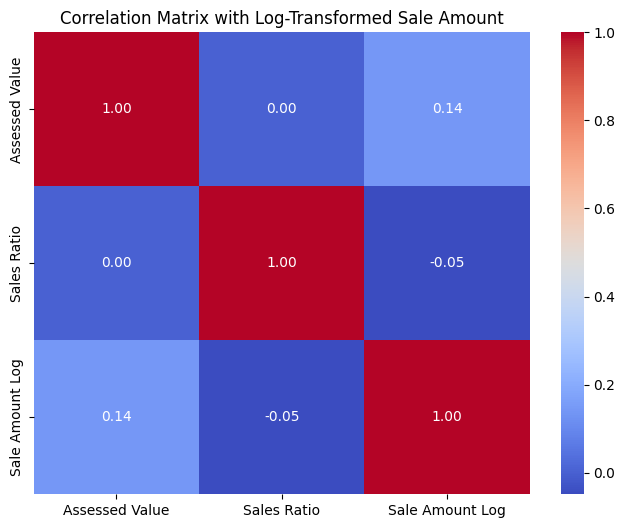

In [11]:
# Add the log-transformed 'Sale Amount Log' column to the correlation matrix
numeric_columns = ['Assessed Value', 'Sales Ratio', 'Sale Amount Log']  # Adjust this list as needed for other numerical features
correlation_matrix = sales_data[numeric_columns].corr()

# Plot the correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix with Log-Transformed Sale Amount")
plt.show()


<ipython-input-12-e2aa5c2ca623>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=town_avg_sale_amount.index, y=town_avg_sale_amount.values, palette="viridis")


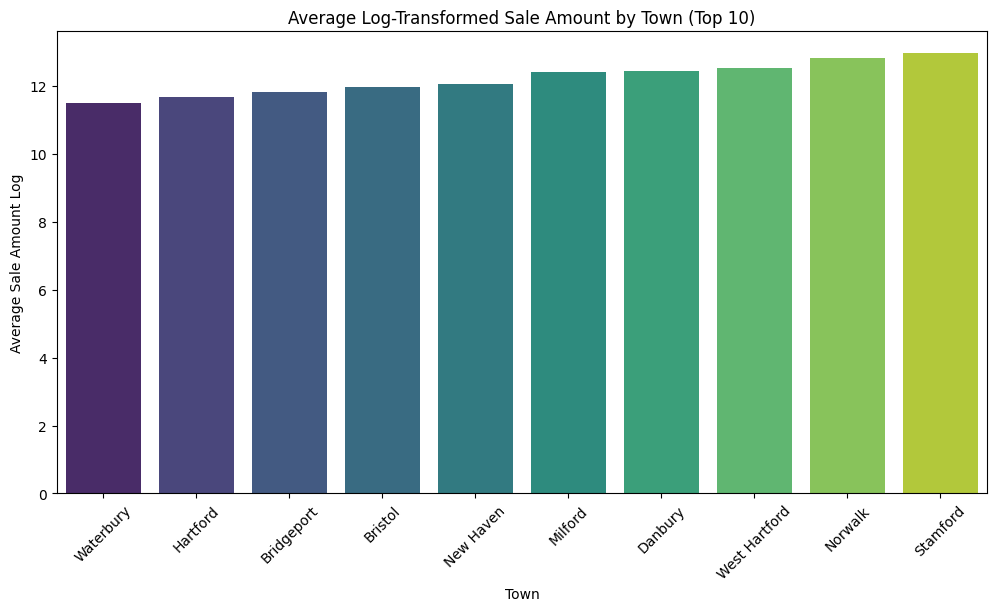

In [12]:
# Calculate the mean Sale Amount Log for each town and sort by frequency
top_towns = sales_data['Town'].value_counts().nlargest(10).index
town_avg_sale_amount = sales_data[sales_data['Town'].isin(top_towns)].groupby('Town')['Sale Amount Log'].mean().sort_values()

# Plotting the average Sale Amount Log by Town
plt.figure(figsize=(12, 6))
sns.barplot(x=town_avg_sale_amount.index, y=town_avg_sale_amount.values, palette="viridis")
plt.title('Average Log-Transformed Sale Amount by Town (Top 10)')
plt.xlabel('Town')
plt.ylabel('Average Sale Amount Log')
plt.xticks(rotation=45)
plt.show()


<ipython-input-13-6060e50aa871>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=property_type_avg_sale_amount.index, y=property_type_avg_sale_amount.values, palette="viridis")


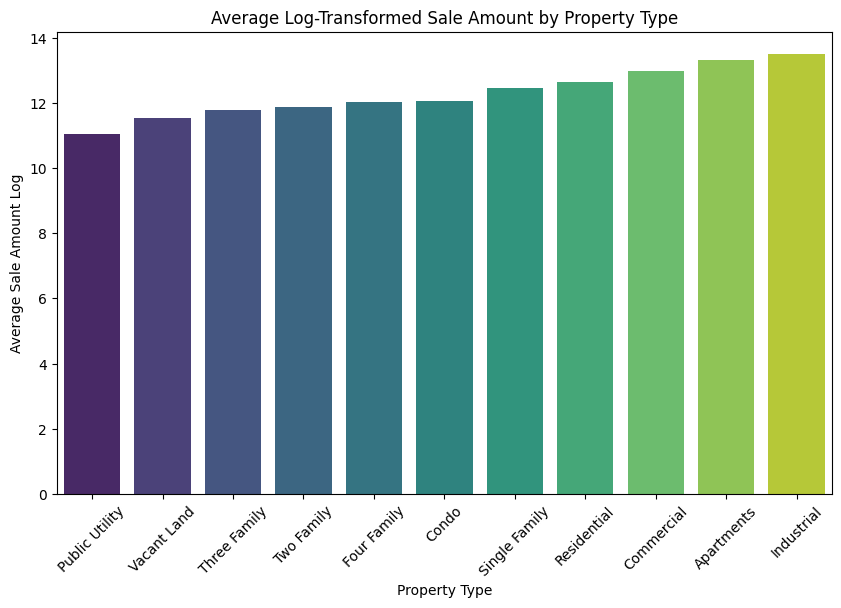

In [13]:
# Calculate the mean Sale Amount Log for each Property Type
property_type_avg_sale_amount = sales_data.groupby('Property Type')['Sale Amount Log'].mean().sort_values()

# Plotting the average Sale Amount Log by Property Type
plt.figure(figsize=(10, 6))
sns.barplot(x=property_type_avg_sale_amount.index, y=property_type_avg_sale_amount.values, palette="viridis")
plt.title('Average Log-Transformed Sale Amount by Property Type')
plt.xlabel('Property Type')
plt.ylabel('Average Sale Amount Log')
plt.xticks(rotation=45)
plt.show()


<ipython-input-14-62286a986b20>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=residential_type_avg_sale_amount.index, y=residential_type_avg_sale_amount.values, palette="viridis")


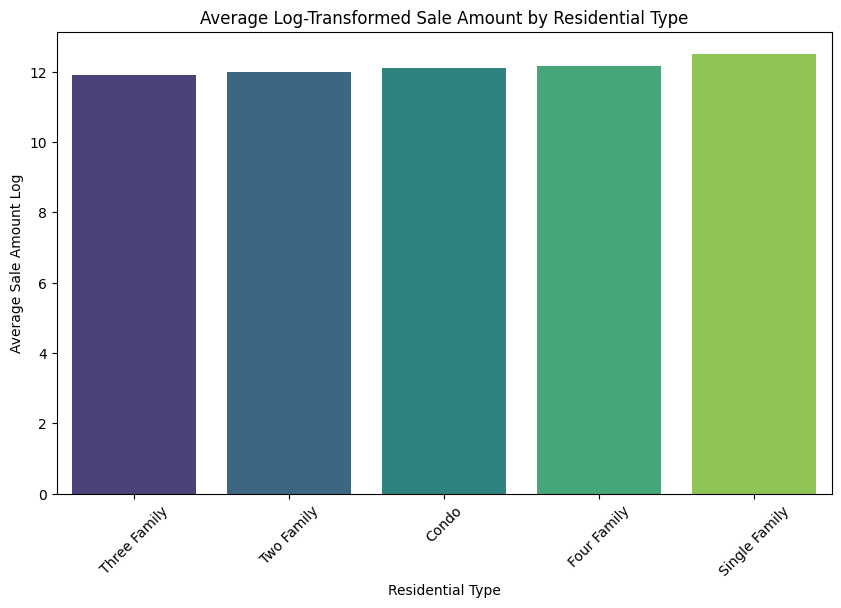

In [14]:
# Calculate the mean Sale Amount Log for each Residential Type
residential_type_avg_sale_amount = sales_data.groupby('Residential Type')['Sale Amount Log'].mean().sort_values()

# Plotting the average Sale Amount Log by Residential Type
plt.figure(figsize=(10, 6))
sns.barplot(x=residential_type_avg_sale_amount.index, y=residential_type_avg_sale_amount.values, palette="viridis")
plt.title('Average Log-Transformed Sale Amount by Residential Type')
plt.xlabel('Residential Type')
plt.ylabel('Average Sale Amount Log')
plt.xticks(rotation=45)
plt.show()


In [15]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Step 1: Target Encoding for 'Town'
# Calculate mean Sale Amount Log for each town
town_target_mean = sales_data.groupby('Town')['Sale Amount Log'].mean()
# Map the mean Sale Amount Log to each town
sales_data['Town_Encoded'] = sales_data['Town'].map(town_target_mean)

# Step 2: One-Hot Encoding for 'Property Type' and 'Residential Type'
# Use pandas get_dummies for one-hot encoding
sales_data = pd.get_dummies(sales_data, columns=['Property Type', 'Residential Type'], drop_first=True)

# Drop the original 'Town' column (if not needed after encoding)
sales_data.drop(columns=['Town'], inplace=True)

# Display the first few rows to confirm the encoding
print(sales_data.head())


   Serial Number  List Year          Address  Assessed Value  Sale Amount  \
0        2020177       2020    323 BEAVER ST          133000     248400.0   
1        2020225       2020   152 JACKSON ST          110500     239900.0   
2        2020348       2020  230 WAKELEE AVE          150500     325000.0   
3        2020090       2020      57 PLATT ST          127400     202500.0   
4         200500       2020     245 NEW ROAD          217640     400000.0   

   Sales Ratio Non Use Code  Sale Amount Log  Town_Encoded  \
0       0.5354      Unknown        12.422800     12.054082   
1       0.4606      Unknown        12.387982     12.054082   
2       0.4630      Unknown        12.691584     12.054082   
3       0.6291      Unknown        12.218500     12.054082   
4       0.5441      Unknown        12.899222     12.767125   

   Property Type_Commercial  ...  Property Type_Public Utility  \
0                     False  ...                         False   
1                     False  ...

In [16]:
# Step 1: Drop irrelevant column 'Address'
if 'Address' in sales_data.columns:
    sales_data = sales_data.drop(columns=['Address'])
    print("Dropped 'Address' column.")

# Step 2: One-hot encode 'Non Use Code'
if 'Non Use Code' in sales_data.columns:
    sales_data = pd.get_dummies(sales_data, columns=['Non Use Code'], drop_first=True)
    print("Applied one-hot encoding to 'Non Use Code'.")

# Step 3: Convert boolean columns to numeric
bool_columns = sales_data.select_dtypes(include=['bool']).columns
if len(bool_columns) > 0:
    sales_data[bool_columns] = sales_data[bool_columns].astype(int)
    print("Converted boolean columns to numeric.")

# Step 4: Verify all columns are numeric
non_numeric_columns = sales_data.select_dtypes(exclude=['number']).columns
if len(non_numeric_columns) == 0:
    print("All columns are numeric. Dataset is ready for modeling!")
else:
    print(f"Non-numeric columns remain: {non_numeric_columns.tolist()}")

# Display the final shape and first few rows of the processed dataset
print(f"Final Sales Dataset Shape: {sales_data.shape}")
print(sales_data.head())


Dropped 'Address' column.
Applied one-hot encoding to 'Non Use Code'.
Converted boolean columns to numeric.
All columns are numeric. Dataset is ready for modeling!
Final Sales Dataset Shape: (1048575, 127)
   Serial Number  List Year  Assessed Value  Sale Amount  Sales Ratio  \
0        2020177       2020          133000     248400.0       0.5354   
1        2020225       2020          110500     239900.0       0.4606   
2        2020348       2020          150500     325000.0       0.4630   
3        2020090       2020          127400     202500.0       0.6291   
4         200500       2020          217640     400000.0       0.5441   

   Sale Amount Log  Town_Encoded  Property Type_Commercial  \
0        12.422800     12.054082                         0   
1        12.387982     12.054082                         0   
2        12.691584     12.054082                         1   
3        12.218500     12.054082                         0   
4        12.899222     12.767125             

In [17]:

# from sklearn.preprocessing import StandardScaler

# # Select numerical columns to scale
# numeric_features = ['Assessed Value', 'Sales Ratio', 'Town_Encoded']
# scaler = StandardScaler()

# # Apply the scaler to the selected numerical columns
# sales_data[numeric_features] = scaler.fit_transform(sales_data[numeric_features])

# # Display the first few rows to confirm scaling
# print(sales_data[numeric_features].head())


In [18]:
# # Step 1: Check for non-numeric columns
# non_numeric_columns = sales_data.select_dtypes(exclude=['number']).columns
# print("Non-numeric columns in Sales Dataset:")
# print(non_numeric_columns)

# # Step 2: Display sample values from non-numeric columns
# if len(non_numeric_columns) > 0:
#     for col in non_numeric_columns:
#         print(f"\nSample data from column '{col}':")
#         print(sales_data[col].unique()[:5])  # Display a few unique values for inspection
# else:
#     print("All columns in Sales Dataset are numeric.")


In [19]:
# Drop irrelevant columns
columns_to_drop = ['Serial Number',  'Sale Amount', 'List Year']  # Add more columns if irrelevant
sales_data_cleaned = sales_data.drop(columns=columns_to_drop, axis=1)

# Display the updated dataset shape and columns
print("Updated Dataset Shape:", sales_data_cleaned.shape)
print("Columns in the Cleaned Dataset:", sales_data_cleaned.columns.tolist())


Updated Dataset Shape: (1048575, 124)
Columns in the Cleaned Dataset: ['Assessed Value', 'Sales Ratio', 'Sale Amount Log', 'Town_Encoded', 'Property Type_Commercial', 'Property Type_Condo', 'Property Type_Four Family', 'Property Type_Industrial', 'Property Type_Public Utility', 'Property Type_Residential', 'Property Type_Single Family', 'Property Type_Three Family', 'Property Type_Two Family', 'Property Type_Vacant Land', 'Residential Type_Four Family', 'Residential Type_Single Family', 'Residential Type_Three Family', 'Residential Type_Two Family', 'Non Use Code_02 - Love and Affection', 'Non Use Code_03 - Inter Corporation', 'Non Use Code_04 - Correcting Deed', 'Non Use Code_05 - Deed Date', 'Non Use Code_06 - Portion of Property', 'Non Use Code_07 - Change in Property', 'Non Use Code_08 - Part Interest', 'Non Use Code_09 - Tax', 'Non Use Code_1', 'Non Use Code_1.0', 'Non Use Code_10', 'Non Use Code_10 - A Will', 'Non Use Code_10.0', 'Non Use Code_11', 'Non Use Code_11 - Court Order'

In [20]:
# Separate features and target
sales_X = sales_data_cleaned.drop(columns=['Sale Amount Log'])  # Features
sales_y = sales_data_cleaned['Sale Amount Log']  # Target

# Display the shapes of the features and target
print("Features Shape:", sales_X.shape)
print("Target Shape:", sales_y.shape)


Features Shape: (1048575, 123)
Target Shape: (1048575,)


In [21]:
# Create a new feature combining Sales Ratio and Assessed Value
sales_X['Value_Ratio_Interaction'] = sales_X['Sales Ratio'] * sales_X['Assessed Value']

# Check the updated feature set
print("Updated Features Shape:", sales_X.shape)


Updated Features Shape: (1048575, 124)


<ipython-input-21-bf7b5858fc96>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_X['Value_Ratio_Interaction'] = sales_X['Sales Ratio'] * sales_X['Assessed Value']


In [22]:
import pandas as pd

# Use pd.concat to efficiently add the new feature
sales_X = pd.concat([sales_X, (sales_X['Sales Ratio'] * sales_X['Assessed Value']).rename('Value_Ratio_Interaction')], axis=1)

# Check the updated feature set
print("Updated Features Shape:", sales_X.shape)


Updated Features Shape: (1048575, 125)


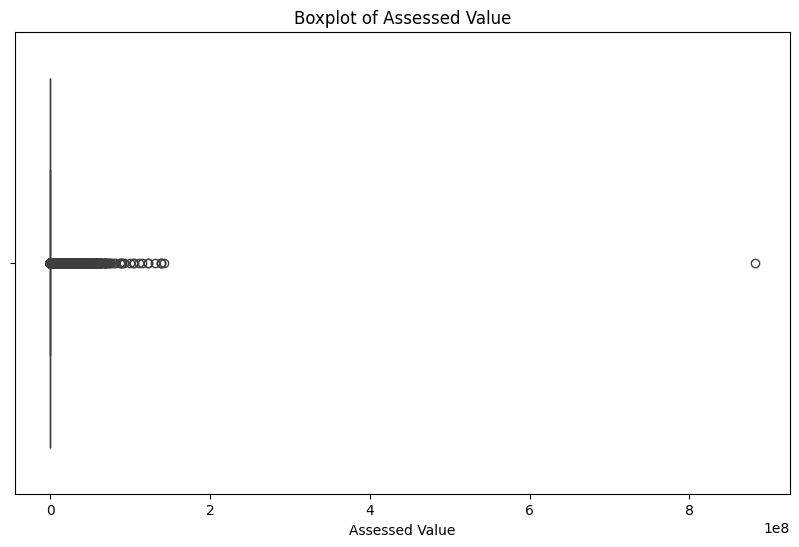

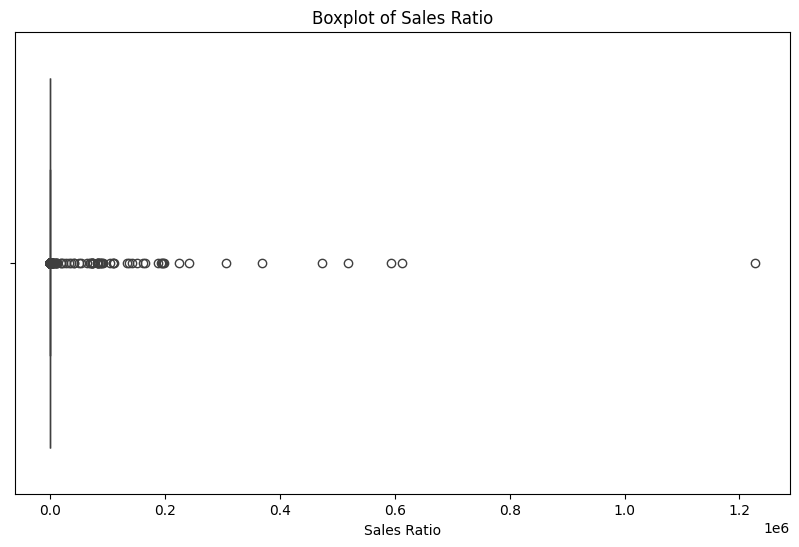

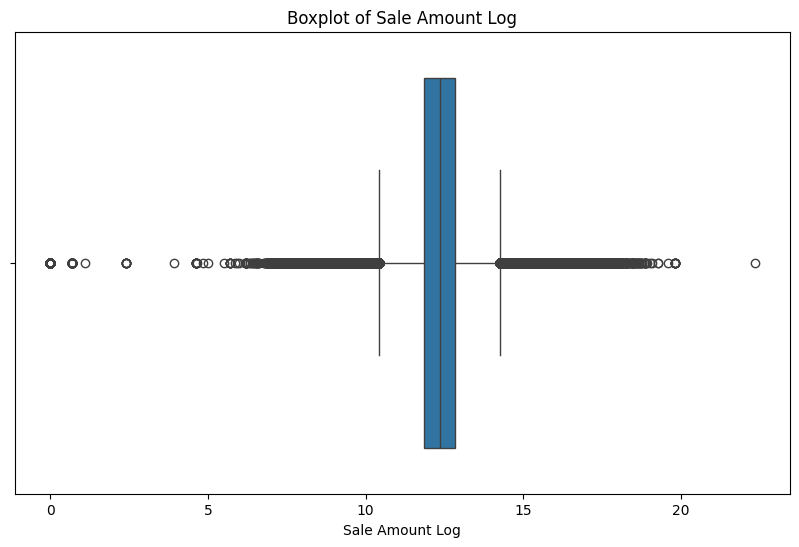

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize 'Assessed Value'
plt.figure(figsize=(10, 6))
sns.boxplot(x=sales_data['Assessed Value'])
plt.title('Boxplot of Assessed Value')
plt.show()

# Visualize 'Sales Ratio'
plt.figure(figsize=(10, 6))
sns.boxplot(x=sales_data['Sales Ratio'])
plt.title('Boxplot of Sales Ratio')
plt.show()

# Visualize 'Sale Amount Log'
plt.figure(figsize=(10, 6))
sns.boxplot(x=sales_data['Sale Amount Log'])
plt.title('Boxplot of Sale Amount Log')
plt.show()


In [24]:
# Calculate IQR for Assessed Value, Sales Ratio, and Sale Amount Log
def calculate_iqr_bounds(column):
    Q1 = sales_data[column].quantile(0.25)
    Q3 = sales_data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Get boundaries for each column
assessed_value_bounds = calculate_iqr_bounds('Assessed Value')
sales_ratio_bounds = calculate_iqr_bounds('Sales Ratio')
sale_amount_log_bounds = calculate_iqr_bounds('Sale Amount Log')

# Print the calculated boundaries
print("Assessed Value Bounds:", assessed_value_bounds)
print("Sales Ratio Bounds:", sales_ratio_bounds)
print("Sale Amount Log Bounds:", sale_amount_log_bounds)


Assessed Value Bounds: (-119070.0, 434210.0)
Sales Ratio Bounds: (0.03845509125000007, 1.22092694525)
Sale Amount Log Bounds: (10.42708196605112, 14.257768400080458)


In [25]:
# Calculate percentile-based bounds for each feature
assessed_value_lower = sales_data['Assessed Value'].quantile(0.01)
assessed_value_upper = sales_data['Assessed Value'].quantile(0.99)
sales_ratio_lower = sales_data['Sales Ratio'].quantile(0.01)
sales_ratio_upper = sales_data['Sales Ratio'].quantile(0.99)
sale_amount_log_lower = sales_data['Sale Amount Log'].quantile(0.01)
sale_amount_log_upper = sales_data['Sale Amount Log'].quantile(0.99)

# Apply the updated bounds to filter the dataset
filtered_sales_data = sales_data[
    (sales_data['Assessed Value'] >= assessed_value_lower) &
    (sales_data['Assessed Value'] <= assessed_value_upper) &
    (sales_data['Sales Ratio'] >= sales_ratio_lower) &
    (sales_data['Sales Ratio'] <= sales_ratio_upper) &
    (sales_data['Sale Amount Log'] >= sale_amount_log_lower) &
    (sales_data['Sale Amount Log'] <= sale_amount_log_upper)
]

# Display the updated dataset size
print(f"Original dataset size: {sales_data.shape[0]}")
print(f"Cleaned dataset size: {filtered_sales_data.shape[0]}")
print(f"Number of outliers removed: {sales_data.shape[0] - filtered_sales_data.shape[0]}")


Original dataset size: 1048575
Cleaned dataset size: 1010218
Number of outliers removed: 38357


In [26]:
print("Features Shape:", sales_X.shape)
print("Target Shape:", sales_y.shape)


Features Shape: (1048575, 125)
Target Shape: (1048575,)


In [27]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
sales_X = filtered_sales_data.drop(columns=['Sale Amount', 'Sale Amount Log'])
sales_y = filtered_sales_data['Sale Amount Log']

# Perform train-test split (80% training, 20% testing)
sales_X_train, sales_X_test, sales_y_train, sales_y_test = train_test_split(
    sales_X, sales_y, test_size=0.2, random_state=42
)

# Display the shapes of the splits
print(f"Training Features: {sales_X_train.shape}")
print(f"Testing Features: {sales_X_test.shape}")
print(f"Training Target: {sales_y_train.shape}")
print(f"Testing Target: {sales_y_test.shape}")


Training Features: (808174, 125)
Testing Features: (202044, 125)
Training Target: (808174,)
Testing Target: (202044,)


In [28]:
from sklearn.model_selection import train_test_split

# Define features and target again from the filtered dataset
sales_X = filtered_sales_data.drop(columns=['Sale Amount Log', 'Sale Amount'])
sales_y = filtered_sales_data['Sale Amount Log']

# Perform the train-test split
sales_X_train, sales_X_test, sales_y_train, sales_y_test = train_test_split(
    sales_X, sales_y, test_size=0.2, random_state=42
)

# Display the shapes of the splits
print("\nRe-Split Dataset Summary:")
print(f"Training Features: {sales_X_train.shape}, Training Target: {sales_y_train.shape}")
print(f"Testing Features: {sales_X_test.shape}, Testing Target: {sales_y_test.shape}")



Re-Split Dataset Summary:
Training Features: (808174, 125), Training Target: (808174,)
Testing Features: (202044, 125), Testing Target: (202044,)


In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Train a simple Linear Regression model
baseline_model = LinearRegression()
baseline_model.fit(sales_X_train, sales_y_train)

# Predict on the test set
sales_y_pred = baseline_model.predict(sales_X_test)

# Evaluate the model
mae = mean_absolute_error(sales_y_test, sales_y_pred)
rmse = np.sqrt(mean_squared_error(sales_y_test, sales_y_pred))
r2 = r2_score(sales_y_test, sales_y_pred)

print("Sales Dataset - Baseline Model Performance:")
print(f"  MAE: {mae:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  R² Score: {r2:.4f}")


Sales Dataset - Baseline Model Performance:
  MAE: 0.2899
  RMSE: 0.4254
  R² Score: 0.7375


In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predict on the test set
sales_y_pred = baseline_model.predict(sales_X_test)

# Evaluate predictions
mae = mean_absolute_error(sales_y_test, sales_y_pred)
rmse = np.sqrt(mean_squared_error(sales_y_test, sales_y_pred))
r2 = r2_score(sales_y_test, sales_y_pred)

# Print evaluation metrics
print("Sales Dataset - Prediction Results:")
print(f"  MAE: {mae:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  R² Score: {r2:.4f}")

# Display first few predictions vs actual values
predictions_vs_actuals = pd.DataFrame({
    "Actual": sales_y_test[:10],
    "Predicted": sales_y_pred[:10]
})
print("\nSample Predictions vs Actual Values:")
print(predictions_vs_actuals)


Sales Dataset - Prediction Results:
  MAE: 0.2899
  RMSE: 0.4254
  R² Score: 0.7375

Sample Predictions vs Actual Values:
           Actual  Predicted
337431  13.000878  12.512502
742615  11.034906  11.314301
874623  12.694656  12.495476
76360    9.952325  11.919324
548571  13.353318  13.124100
797096  10.689670  11.151353
787678  12.043560  12.209031
485819  12.491406  12.117182
648656  11.652696  11.864226
905606  12.468441  12.308329


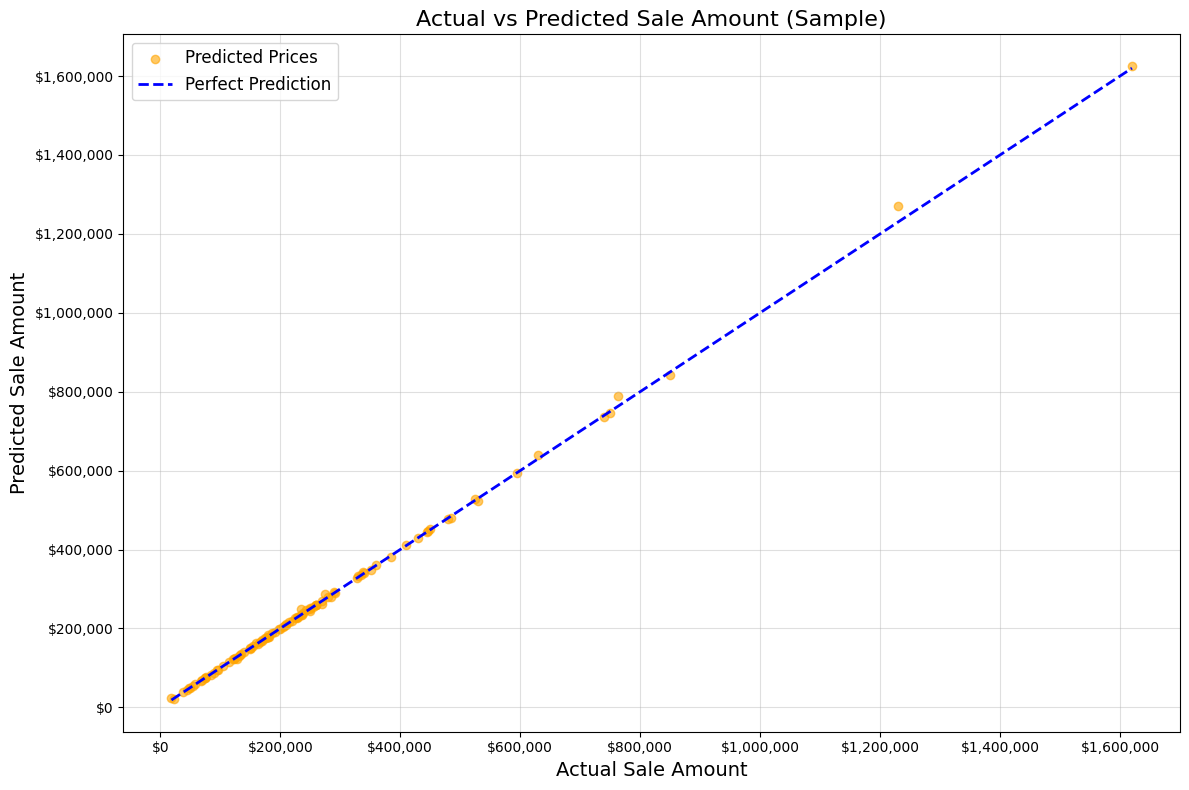

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Reset index to ensure sequential indexing for sampling
actual_prices = np.expm1(sales_y_test.reset_index(drop=True))  # Reverse log1p transformation
predicted_prices = np.expm1(sales_y_pred)

# Take a smaller sample of data for clear visualization
sample_indices = np.random.choice(len(actual_prices), size=100, replace=False)  # 50 for cleaner graph
sample_actual_prices = actual_prices.iloc[sample_indices]
sample_predicted_prices = predicted_prices[sample_indices]

# Scatter plot for actual vs predicted values
plt.figure(figsize=(12, 8))
plt.scatter(sample_actual_prices, sample_predicted_prices,
            label="Predicted Prices", alpha=0.6, color='orange')
plt.plot([min(sample_actual_prices), max(sample_actual_prices)],
         [min(sample_actual_prices), max(sample_actual_prices)],
         label="Perfect Prediction", color='blue', linestyle='--', linewidth=2)

# Enhance the graph
plt.title("Actual vs Predicted Sale Amount (Sample)", fontsize=16)
plt.xlabel("Actual Sale Amount", fontsize=14)
plt.ylabel("Predicted Sale Amount", fontsize=14)
plt.legend(fontsize=12)

# Format axes with commas for large numbers
plt.gca().xaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

plt.grid(alpha=0.4)
plt.tight_layout()

# Display the plot
plt.show()


In [36]:
!pip install lightgbm


In [37]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Prepare data for LightGBM
train_data = lgb.Dataset(sales_X_train, label=sales_y_train)
test_data = lgb.Dataset(sales_X_test, label=sales_y_test, reference=train_data)

# Define parameters for LightGBM
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'random_state': 42
}

# Train the model with early stopping
lgb_model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'valid'],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=100)]
)

# Predict on test data
sales_y_pred = lgb_model.predict(sales_X_test, num_iteration=lgb_model.best_iteration)

# Calculate metrics
mae = mean_absolute_error(sales_y_test, sales_y_pred)
rmse = np.sqrt(mean_squared_error(sales_y_test, sales_y_pred))
r2 = r2_score(sales_y_test, sales_y_pred)

print("LightGBM Model Performance:")
print(f"  MAE: {mae:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  R² Score: {r2:.4f}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.156903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 808174, number of used features: 97
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 12.331898
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 0.0378218	valid's rmse: 0.0390038
[200]	train's rmse: 0.0351296	valid's rmse: 0.0371599
[300]	train's rmse: 0.0335315	valid's rmse: 0.0364796
[400]	train's rmse: 0.0321827	valid's rmse: 0.0359394
[500]	train's rmse: 0.0312662	valid's rmse: 0.0356142
[600]	train's rmse: 0.0306193	valid's rmse: 0.0352904
[700]	train's rmse: 0.0299356	valid's rmse: 0.0

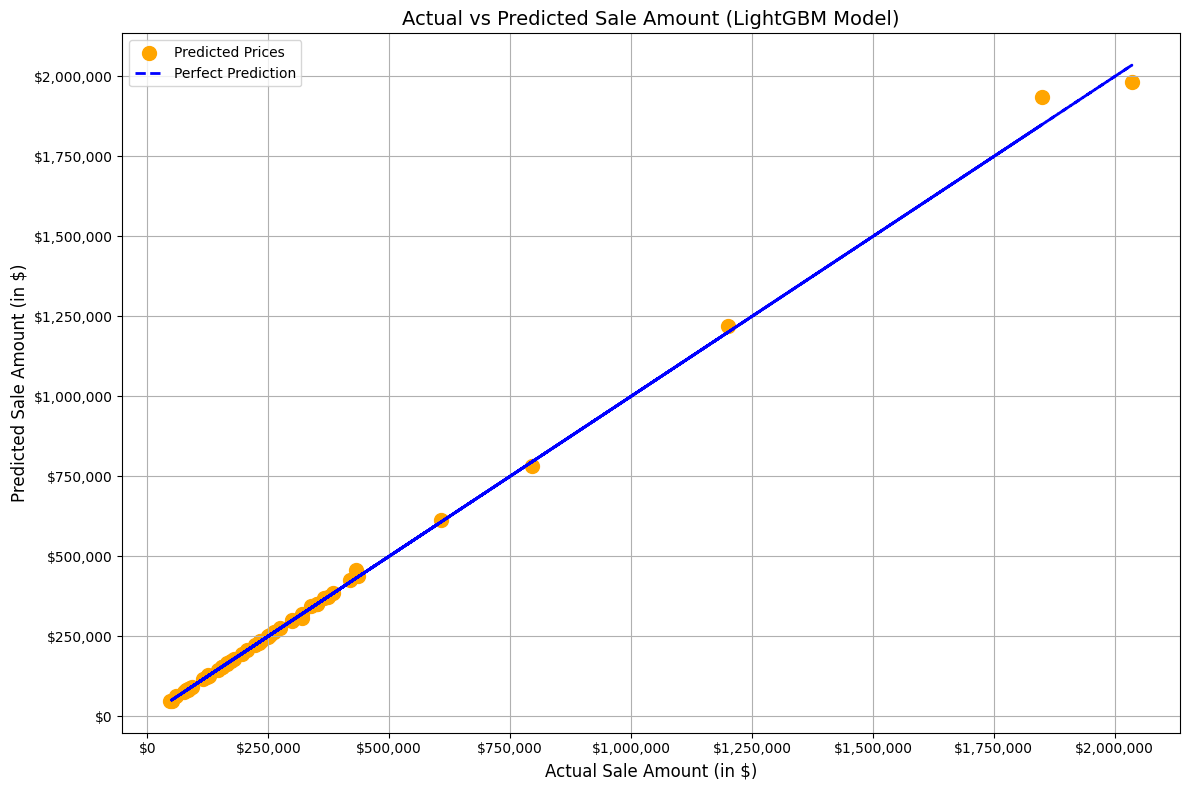

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Define actual and predicted values
actual_values = np.expm1(sales_y_test.reset_index(drop=True))  # Reverse log transformation for actual values
predicted_values = np.expm1(sales_y_pred)  # Reverse log transformation for predicted values

# Sample only 50 predictions for a cleaner graph
sample_indices = np.random.choice(len(actual_values), size=50, replace=False)
sample_actual_values = actual_values.iloc[sample_indices].reset_index(drop=True)
sample_predictions = pd.Series(predicted_values[sample_indices]).reset_index(drop=True)

# Plot Actual vs Predicted values
plt.figure(figsize=(12, 8))
plt.scatter(sample_actual_values, sample_predictions, color="orange", label="Predicted Prices", s=100)
plt.plot(sample_actual_values, sample_actual_values, color="blue", linestyle="--", label="Perfect Prediction", linewidth=2)

# Format axes to show dollar values
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

# Customize the plot
plt.xlabel("Actual Sale Amount (in $)", fontsize=12)
plt.ylabel("Predicted Sale Amount (in $)", fontsize=12)
plt.title("Actual vs Predicted Sale Amount (LightGBM Model)", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


In [45]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Scale the features
scaled_features = scaler.fit_transform(sales_X)

# Convert back to a DataFrame for better readability
sales_X_scaled = pd.DataFrame(scaled_features, columns=sales_X.columns)

# Display the scaled features
print("Scaled Features Shape:", sales_X_scaled.shape)
print(sales_X_scaled.head())


Scaled Features Shape: (1010218, 125)
   Serial Number  List Year  Assessed Value  Sales Ratio  Town_Encoded  \
0       0.234271   1.413141       -0.307171    -0.334494     -0.454147   
1       0.234278   1.413141       -0.414898    -0.467444     -0.454147   
2       0.234297   1.413141       -0.223383    -0.463178     -0.454147   
3       0.234258   1.413141       -0.333983    -0.167951     -0.454147   
4      -0.039980   1.413141        0.098076    -0.319030      0.917564   

   Property Type_Commercial  Property Type_Condo  Property Type_Four Family  \
0                 -0.056671            -0.337115                  -0.045761   
1                 -0.056671            -0.337115                  -0.045761   
2                 17.645797            -0.337115                  -0.045761   
3                 -0.056671            -0.337115                  -0.045761   
4                 -0.056671            -0.337115                  -0.045761   

   Property Type_Industrial  Property Type

In [46]:
from sklearn.model_selection import train_test_split

# Split the scaled data into training and testing sets (80-20 split)
sales_X_train, sales_X_test, sales_y_train, sales_y_test = train_test_split(
    sales_X_scaled, sales_y, test_size=0.2, random_state=42
)

# Display the shapes of the splits
print("Training Features Shape:", sales_X_train.shape)
print("Testing Features Shape:", sales_X_test.shape)
print("Training Target Shape:", sales_y_train.shape)
print("Testing Target Shape:", sales_y_test.shape)


Training Features Shape: (808174, 125)
Testing Features Shape: (202044, 125)
Training Target Shape: (808174,)
Testing Target Shape: (202044,)


In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the deep learning model architecture
dl_model = Sequential([
    Dense(128, activation='relu', input_shape=(sales_X_train.shape[1],)),
    Dropout(0.3),  # Dropout layer to prevent overfitting
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')  # Output layer for regression
])

# Compile the model
dl_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Print the model summary
dl_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │          16,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,497 (103.50 KB)

 Trainable params: 26,497 (103.50 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

# Train the model
history = dl_model.fit(
    sales_X_train, sales_y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/100
20205/20205 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 2.9578 - mae: 0.8467 - val_loss: 0.0679 - val_mae: 0.2029 - learning_rate: 0.0010
Epoch 2/100
20205/20205 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - loss: 0.0598 - mae: 0.1167 - val_loss: 0.0436 - val_mae: 0.1501 - learning_rate: 0.0010
Epoch 3/100
20205/20205 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - loss: 0.0323 - mae: 0.0966 - val_loss: 0.0317 - val_mae: 0.1050 - learning_rate: 0.0010
Epoch 4/100
20205/20205 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - loss: 0.0290 - mae: 0.0884 - val_loss: 0.0235 - val_mae: 0.0951 - learning_rate: 0.0010
Epoch 5/100
20205/20205 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - loss: 0.0318 - mae: 0.0849 - val_loss: 0.0232 - val_mae: 0.0927 - learning_rate: 0.0010
Epoch 6/100
20205/20205 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - loss: 0.0272 - mae: 0.0822 - val_loss: 0.0217 - val_mae: 0.0924 - learning_rate: 0.0010
Epoch 7/100
20205/20205 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - loss: 0.0254 - mae: 0.0790 - val_loss: 0.0196 - val_

In [49]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predict on the test set
sales_y_pred = dl_model.predict(sales_X_test)

# Reverse the log transformation to get original sale prices
sales_y_test_actual = np.expm1(sales_y_test)  # Reverse of log1p
sales_y_pred_actual = np.expm1(sales_y_pred.flatten())

# Calculate evaluation metrics
mae = mean_absolute_error(sales_y_test_actual, sales_y_pred_actual)
rmse = np.sqrt(mean_squared_error(sales_y_test_actual, sales_y_pred_actual))
r2 = r2_score(sales_y_test_actual, sales_y_pred_actual)

# Print evaluation metrics
print("Deep Learning Model Performance:")
print(f"  MAE: {mae:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  R² Score: {r2:.4f}")


6314/6314 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
Deep Learning Model Performance:
  MAE: 19713.3504
  RMSE: 71931.1823
  R² Score: 0.9518


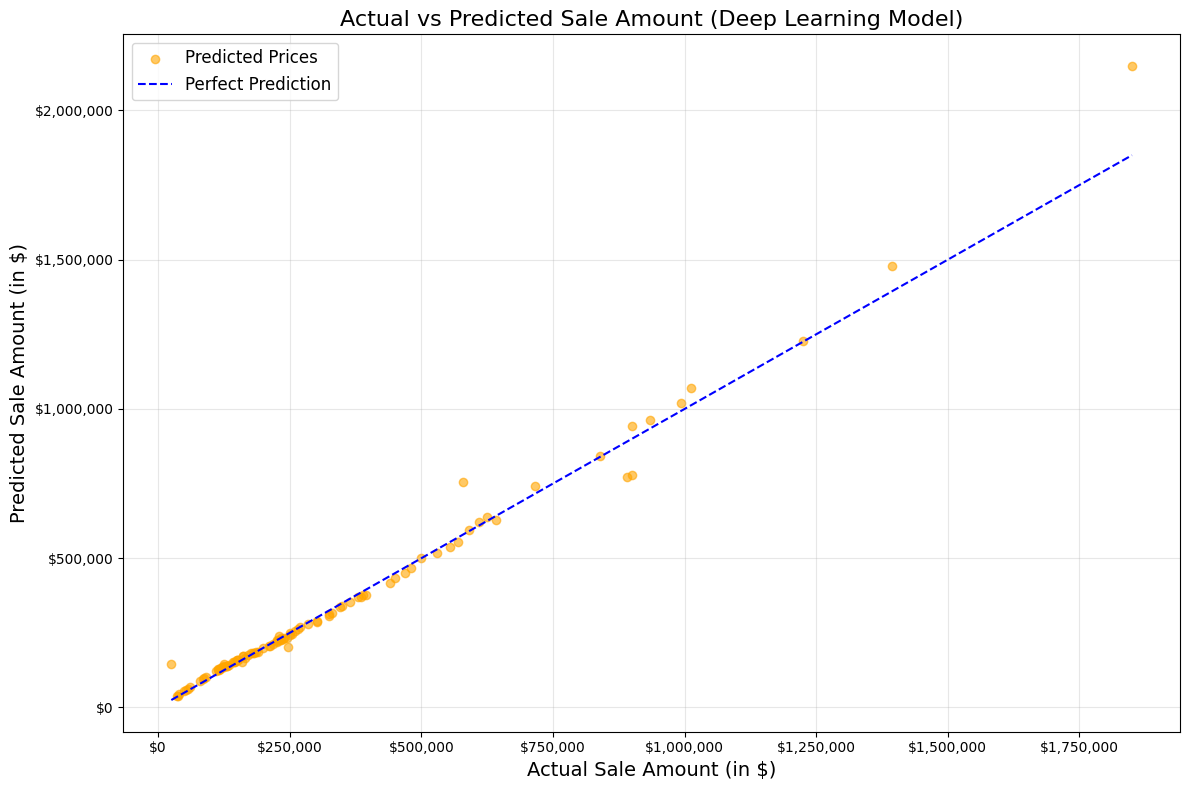

In [51]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Reset the index for proper alignment
sales_y_test_actual_reset = sales_y_test_actual.reset_index(drop=True)
sales_y_pred_actual_reset = pd.Series(sales_y_pred_actual).reset_index(drop=True)

# Take a sample of the data for better visualization
sample_indices = np.random.choice(len(sales_y_test_actual_reset), size=100, replace=False)
sample_actual_prices = sales_y_test_actual_reset.iloc[sample_indices]
sample_predicted_prices = sales_y_pred_actual_reset.iloc[sample_indices]

# Scatter plot for actual vs predicted values
plt.figure(figsize=(12, 8))
plt.scatter(sample_actual_prices, sample_predicted_prices, color="orange", alpha=0.6, label="Predicted Prices")
plt.plot([min(sample_actual_prices), max(sample_actual_prices)],
         [min(sample_actual_prices), max(sample_actual_prices)],
         color="blue", linestyle="--", label="Perfect Prediction")

# Add labels and formatting
plt.title("Actual vs Predicted Sale Amount (Deep Learning Model)", fontsize=16)
plt.xlabel("Actual Sale Amount (in $)", fontsize=14)
plt.ylabel("Predicted Sale Amount (in $)", fontsize=14)
plt.legend(fontsize=12)

# Format axes to display currency
plt.gca().xaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [52]:
!pip install keras-tuner --quiet



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.2 MB/s eta 0:00:00


In [53]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the model building function
def build_model(hp):
    model = Sequential()

    # Input Layer
    model.add(Dense(
        units=hp.Int("units_input", min_value=64, max_value=256, step=32),
        activation="relu",
        input_shape=(sales_X_train.shape[1],)  # Input features
    ))
    model.add(Dropout(hp.Float("dropout_input", min_value=0.0, max_value=0.5, step=0.1)))

    # Hidden Layers
    for i in range(hp.Int("num_layers", 1, 3)):  # Tune the number of hidden layers (1-3)
        model.add(Dense(
            units=hp.Int(f"units_{i}", min_value=32, max_value=128, step=32),
            activation="relu"
        ))
        model.add(Dropout(hp.Float(f"dropout_{i}", min_value=0.0, max_value=0.5, step=0.1)))

    # Output Layer
    model.add(Dense(1, activation="linear"))  # Regression problem

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")),
        loss="mse",
        metrics=["mae"]
    )

    return model


In [54]:
from keras_tuner import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping

# Define the tuner
tuner = RandomSearch(
    build_model,
    objective="val_mae",  # We optimize for the validation MAE
    max_trials=10,        # Number of model configurations to try
    executions_per_trial=1,  # Number of times to train each configuration
    directory="tuning_dir",  # Directory to save results
    project_name="sales_price_tuning"  # Project name for the logs
)

# Define early stopping for faster tuning
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Start the hyperparameter search
tuner.search(
    sales_X_train, sales_y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)


Trial 10 Complete [00h 11m 25s]
val_mae: 0.05349290370941162

Best val_mae So Far: 0.020610613748431206
Total elapsed time: 02h 10m 26s


In [55]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]
print("Best Hyperparameters Found:")
print(best_hps.values)

# Build and train the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    sales_X_train, sales_y_train,
    validation_data=(sales_X_test, sales_y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_mae = best_model.evaluate(sales_X_test, sales_y_test, verbose=1)
print(f"Test MAE: {test_mae:.4f}")


Best Hyperparameters Found:
{'units_input': 192, 'dropout_input': 0.2, 'num_layers': 3, 'units_0': 32, 'dropout_0': 0.0, 'lr': 0.00014019410557845397, 'units_1': 128, 'dropout_1': 0.0, 'units_2': 32, 'dropout_2': 0.0}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
25256/25256 ━━━━━━━━━━━━━━━━━━━━ 52s 2ms/step - loss: 5.7643 - mae: 1.0201 - val_loss: 0.0726 - val_mae: 0.0907
Epoch 2/50
25256/25256 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step - loss: 0.0756 - mae: 0.1147 - val_loss: 0.0235 - val_mae: 0.0573
Epoch 3/50
25256/25256 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step - loss: 0.0973 - mae: 0.0815 - val_loss: 0.0129 - val_mae: 0.0345
Epoch 4/50
25256/25256 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step - loss: 0.0323 - mae: 0.0649 - val_loss: 0.0101 - val_mae: 0.0288
Epoch 5/50
25256/25256 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step - loss: 0.0229 - mae: 0.0566 - val_loss: 0.0107 - val_mae: 0.0267
Epoch 6/50
25256/25256 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step - loss: 0.0350 - mae: 0.0510 - val_loss: 0.0085 - val_mae: 0.0339
Epoch 7/50
25256/25256 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step - loss: 0.0130 - mae: 0.0466 - val_loss: 0.0082 - val_mae: 0.0270
Epoch 8/50
25256/25256 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step - loss: 0.0168 - mae: 0.0444 - val_loss: 0.0075 - val_mae: 0.0320
Epoch 9/50
25256

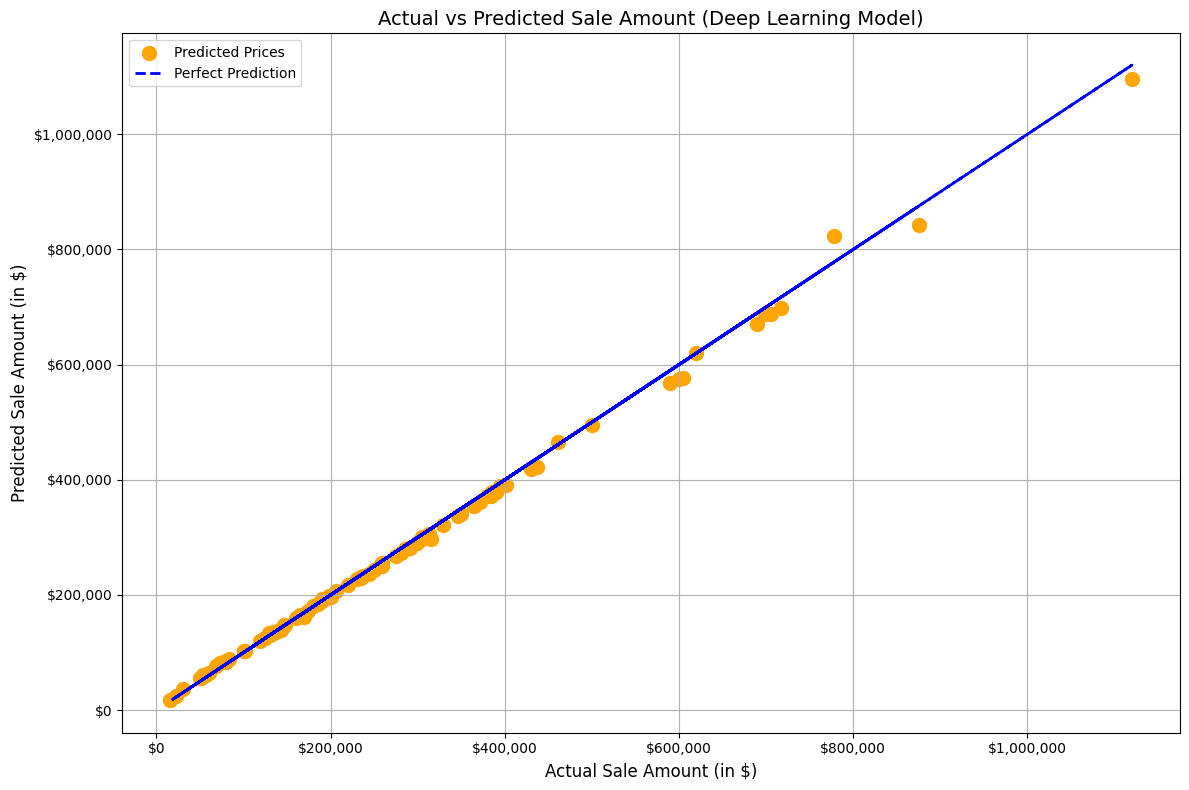

In [58]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

# Ensure the actual test data has sequential indices
sales_y_test_actual_reset = sales_y_test_actual.reset_index(drop=True)

# Take a sample of indices for visualization
sample_indices = np.random.choice(len(sales_y_test_actual_reset), size=100, replace=False)

# Extract the sample actual and predicted values
sample_actual_prices = sales_y_test_actual_reset.iloc[sample_indices]  # Use .iloc for pandas Series
sample_predicted_prices = sales_y_pred_actual[sample_indices]         # Direct access for NumPy array

# Plot Actual vs Predicted Sale Amount
plt.figure(figsize=(12, 8))
plt.scatter(sample_actual_prices, sample_predicted_prices, color="orange", label="Predicted Prices", s=100)
plt.plot(sample_actual_prices, sample_actual_prices, color="blue", linestyle="--", label="Perfect Prediction", linewidth=2)

# Format axes to show dollar values
plt.gca().xaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

# Customize the plot
plt.xlabel("Actual Sale Amount (in $)", fontsize=12)
plt.ylabel("Predicted Sale Amount (in $)", fontsize=12)
plt.title("Actual vs Predicted Sale Amount (Deep Learning Model)", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


In [62]:
# Save the trained model
best_model.save("my_model.keras")
print("Best model saved as 'best_sales_model.h5'.")


Best model saved as 'best_sales_model.h5'.


In [63]:
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import tensorflow.keras.losses

# Register 'mse' for compatibility when loading the model
tensorflow.keras.losses.mse = tensorflow.keras.losses.MeanSquaredError()

# Load the saved model
best_model = load_model("my_model.keras")

# Predict on the test data
sales_y_pred = best_model.predict(sales_X_test).flatten()

# Reverse the log transformation to get the original prices
sales_y_test_original = np.expm1(sales_y_test)  # Actual values
sales_y_pred_original = np.expm1(sales_y_pred)  # Predicted values

# Calculate evaluation metrics
mae = mean_absolute_error(sales_y_test_original, sales_y_pred_original)
rmse = np.sqrt(mean_squared_error(sales_y_test_original, sales_y_pred_original))
r2 = r2_score(sales_y_test_original, sales_y_pred_original)

# Print the R² Score and other metrics
print("Deep Learning Model Performance:")
print(f"  MAE: {mae:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  R² Score: {r2:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


6314/6314 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
Deep Learning Model Performance:
  MAE: 8488.3272
  RMSE: 203056.9414
  R² Score: 0.6162


In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Updated Deep Learning Model
updated_model = Sequential([
    Dense(256, activation='relu', input_shape=(sales_X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),

    Dense(1, activation='linear')  # Output layer for regression
])

# Compile the model with a lower learning rate
updated_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

# Train the model
history = updated_model.fit(
    sales_X_train, sales_y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,  # Larger batch size
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
10103/10103 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - loss: 16.7523 - mae: 2.2401 - val_loss: 0.4823 - val_mae: 0.2216 - learning_rate: 0.0010
Epoch 2/100
10103/10103 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 0.4292 - mae: 0.5172 - val_loss: 0.1297 - val_mae: 0.1969 - learning_rate: 0.0010
Epoch 3/100
10103/10103 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 0.2712 - mae: 0.4098 - val_loss: 0.3419 - val_mae: 0.1229 - learning_rate: 0.0010
Epoch 4/100
10103/10103 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 0.1725 - mae: 0.3255 - val_loss: 0.7305 - val_mae: 0.1043 - learning_rate: 0.0010
Epoch 5/100
10103/10103 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 0.1114 - mae: 0.2595 - val_loss: 2.8283 - val_mae: 0.0813 - learning_rate: 0.0010
Epoch 6/100
10103/10103 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 0.0746 - mae: 0.2102 - val_loss: 0.2112 - val_mae: 0.1044 - learning_rate: 0.0010
Epoch 7/100
10103/10103 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 0.0544 - mae: 0.1773 - val_loss: 0.1442 - val

KeyboardInterrupt: 